In [1]:
import os # 修改工作目录

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from jupyterquiz import display_quiz

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import f
from scipy.stats import t

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
plt.rcParams['font.sans-serif'] = ['SimHei']	# 显示中文
plt.rcParams['axes.unicode_minus'] = False		# 显示负号

## 导入数据

In [2]:
Data = pd.read_csv("Project_3.csv").set_axis(["x1", "x2", "x3", "Y"], axis="columns")
print(Data.head())

     x1  x2   x3    Y
0  2000  90  100  225
1  1800  94   95  212
2  2400  88  110  229
3  1900  91   96  222
4  1600  86  100  219


## 参数设置

In [3]:
alpha = 0.05

# 数据规模
n = Data.shape[0]
p = Data.shape[1] - 1
print("The number of instances is ", n)
print("The number of features is ", p)

The number of instances is  12
The number of features is  3


### Task1 请用多元线性回归模型，描述制动马力和发动机转速、道路辛烷值以及压缩值之间的函数关系。

In [4]:
## Method 1: Matrix Calculus
Data1 = sm.add_constant(Data)
Data1_value = Data1.values
X = Data1_value[:,0:(p+1)]
y = Data1_value[:,-1]
beta_hat_1 = np.linalg.inv(X.T @ X) @ (X.T @ y)
# A @ B <=> np.dot(A,B) matrix multiply

print("The estimates of the parameters are \n", 
      np.around(beta_hat_1,4))

The estimates of the parameters are 
 [-2.660312e+02  1.070000e-02  3.134800e+00  1.867400e+00]


可以得到截距项为-266.0312, 发动机转速对应的系数为0.0107, 道路辛烷值对应的系数为3.1348, 压缩值对应的系数为1.8674

In [5]:
## Method 3: 「scikit-learn」package
model = linear_model.LinearRegression()
X_without_intercept = X[:,1:p+1]
model.fit(X_without_intercept, y)
beta_hat = np.append(np.array(model.intercept_),model.coef_)
print("The estimates of the parameters are \n", 
      np.around(beta_hat,4))

The estimates of the parameters are 
 [-2.660312e+02  1.070000e-02  3.134800e+00  1.867400e+00]


直接调用机器学习相关包得到相同的结果

### Task2 分别将数据中心化、标准化之后，比较参数估计的异同，并进行评述（提示：可以结合理论课的课件）。

In [6]:
## 中心化
X_center = preprocessing.scale(X_without_intercept, with_mean = True, with_std=False)
y_center = preprocessing.scale(y, with_mean = True, with_std=False)

print("The sample means of centered features are ", np.around(np.mean(X_center,axis=0),4))
print("The sample mean of centered response is ", np.around(np.mean(y_center,axis=0),4))

The sample means of centered features are  [-0. -0.  0.]
The sample mean of centered response is  0.0


均值为0，中心化成功

In [7]:
model_center = linear_model.LinearRegression()
model_center.fit(X_center, y_center)
beta_hat_center = np.append(np.array(model_center.intercept_),model_center.coef_)
print("The estimates of the parameters are \n", 
          np.around(beta_hat_center,4))

The estimates of the parameters are 
 [0.     0.0107 3.1348 1.8674]


得到截距项变为0，三个系数分别为0.0107，3.1348，1.8674，与未中心化的结果相同

In [8]:
## 标准化
x_std_value = np.std(X_without_intercept, axis=0)
y_std_value = np.std(y)
print("三个变量的标准差分别为 \n", x_std_value)
print("y的标准差为", y_std_value)

X_std = preprocessing.scale(X_without_intercept, with_mean = True)
y_std = preprocessing.scale(y, with_mean = True)

print("The sample means of centered features are ", np.around(np.std(X_std,axis=0),4))
print("The sample mean of centered response is ", np.around(np.std(y_std,axis=0),4))

三个变量的标准差分别为 
 [573.66995932   3.02305952   4.79800306]
y的标准差为 16.357974609753292
The sample means of centered features are  [1. 1. 1.]
The sample mean of centered response is  1.0


标准差均为1，标准化成功

In [9]:
model_std = linear_model.LinearRegression()
model_std.fit(X_std, y_std)
beta_hat_std = np.append(np.array(model_std.intercept_),model_std.coef_)
print("The estimates of the parameters are \n", 
          np.around(beta_hat_std,4))

The estimates of the parameters are 
 [0.     0.3757 0.5793 0.5477]


In [10]:
# 使用标准化与中心化斜率转换公式
L = np.diag(1 / (x_std_value * np.sqrt(n)))
print("L矩阵为: \n", L)

beta_hat_std_theory = 1 / (y_std_value * np.sqrt(n)) * np.linalg.inv(L) @ beta_hat_center[1:]
print("三个标准化变量对应的系数为: \n", beta_hat_std_theory)

L矩阵为: 
 [[0.00050321 0.         0.        ]
 [0.         0.09549105 0.        ]
 [0.         0.         0.06016568]]
三个标准化变量对应的系数为: 
 [0.37570944 0.57933248 0.54773506]


### Task3: 从模型显著性、参数显著性以及残差分析三个角度，分析多元线性回归模型是否合理。

In [11]:
model1 = ols("Y~x1 + x2 + x3", Data).fit()
beta_hat = model1.params

print("The estimates of the parameters are \n", 
      round(beta_hat,4))

The estimates of the parameters are 
 Intercept   -266.0312
x1             0.0107
x2             3.1348
x3             1.8674
dtype: float64


In [12]:
model1.summary()

d:\anaconda\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     11.12
Date:                Mon, 09 Oct 2023   Prob (F-statistic):            0.00317
Time:                        21:32:11   Log-Likelihood:                -40.708
No. Observations:                  12   AIC:                             89.42
Df Residuals:                       8   BIC:                             91.36
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -266.0312     92.674     -2.871      0.021    -479.737     -52.325
x1             0.0107      0.004      2.390      0.044       0.000       0.021
x2             3.1348      0.844      3.712      0.006       1.188       5.082
x3             1.8674      0.535      3.494      0.008       0.635       3.100
==============================================================================
Omnibus:                        0.392   Durbin-Watson:                   1.043
Prob(Omnibus):                  0.822   Jarque-Bera (JB):                0.230
Skew:                          -0.282   Prob(JB):                        0.891
Kurtosis:                       2.625   Cond. No.                     9.03e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 模型显著性

F统计量对应的p值为0.00317，小于显著性水平0.05，所以该模型是显著的。

#### 参数显著性

三个变量的t统计量分别为0.044，0.006，0.008，均小于0.05，可见这三个变量都是显著的。

此外，三个变量对应的系数的预测区间均不包含0，可以看出制动马力与这三个变量成正相关。

In [13]:
y_hat = X @ beta_hat_1
print("y的预测值为\n", y_hat)

y的预测值为
 [224.26871063 225.32824692 240.95847559 218.86255836 207.44420245
 267.10824644 243.78632464 237.12456005 235.90671156 221.12574828
 222.12606905 233.96014603]


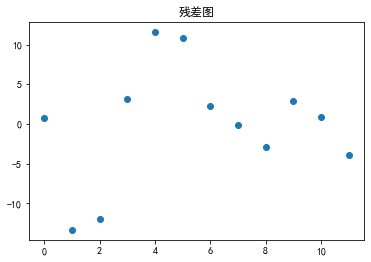

In [14]:
Res = y - y_hat
plt.scatter(range(Res.size), Res)
plt.title("残差图")
plt.show()

In [15]:
DW = durbin_watson(Res)
print("DW statistic is", round(DW,4))

DW statistic is 1.0431


当样本量为12，回归变量个数为3时，$dL$和$dU$分别为0.658和1.864，所以无法确定

In [16]:
data1 = Res[:6]
data2 = Res[6:]
Bart_stat, Bart_pVal = stats.bartlett(data1, data2)
print("Bartlett's test statistic is", round(Bart_stat,4))
print("The p value is", round(Bart_pVal,4))
# https://mp.weixin.qq.com/s?__biz=MzI2OTQyMzc5MA==&mid=2247497134&idx=1&sn=c741484a9f1e78740c15fdb72074eda5&chksm=eae2306fdd95b97952c4014fc9db5001d4b995ffe8d08423012e19df5505793245788b592b8c&scene=27

Bartlett's test statistic is 6.6956
The p value is 0.0097


In [17]:
Lev_stat, Lev_pVal = stats.levene(data1, data2)
print("Levene's test statistic is", round(Lev_stat,4))
print("The p value is", round(Lev_pVal,4))

Levene's test statistic is 5.9289
The p value is 0.0352


根据bartlett检验和修正后的levene检验，p值均小于0.05，即未通过方差齐性检验

In [18]:
SW_stat,SW_pVal = stats.shapiro(Res)
print("Shapiro-Wilk test statistic is", round(SW_stat,4))
print("The p value is", round(SW_pVal,4))

Shapiro-Wilk test statistic is 0.9291
The p value is 0.3706


使用Shapiro-Wilk检验，p值大于显著性水平，所以接受原假设，即通过正态性检验

### 结论

- 无法确定独立性
- 方差齐性检验未通过
- 正态性检验通过

### Task4: 若取发动机转速为3000转/min，道路辛烷值为90，发动机压缩值为100时，分别给出制动马力值的置信区间和预测区间。

In [19]:
## 自定义函数

def prediction_interval(x0,X,y):
    # Add intercept to the new vector
    x0 = np.append(1,x0)
    # Parameter setting
    n = X.shape[0]
    p = X.shape[1]-1
    # Modelling
    beta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y) # parameter estimation
    y_fitted = X @ beta_hat # fitted value
    e = y_fitted - y # residuals
    sigma2 = sum(e**2)/(n - p - 1) # estimate of sigma2
    # Interval Construction
    tVal = t.ppf(1-alpha/2, n- p - 1) # quantile
    delta = tVal*np.sqrt(sigma2)*np.sqrt(1 + x0.T @ np.linalg.inv(X.T @ X) @ x0)
    y0_fitted = x0 @ beta_hat
    output = [y0_fitted - delta, y0_fitted + delta] # prediction interval
    return output


def confidence_interval(x0,X,y):
    # Add intercept to the new vector
    x0 = np.append(1,x0)
    # Parameter setting
    n = X.shape[0]
    p = X.shape[1]-1
    # Modelling
    beta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y) # parameter estimation
    y_fitted = X @ beta_hat # fitted value
    e = y_fitted - y # residuals
    sigma2 = sum(e**2)/(n - p - 1) # estimate of sigma2
    # Interval Construction
    tVal = t.ppf(1-alpha/2, n- p - 1) # quantile
    delta = tVal*np.sqrt(sigma2)*np.sqrt(x0.T @ np.linalg.inv(X.T @ X) @ x0)
    y0_fitted = x0 @ beta_hat
    output = [y0_fitted - delta, y0_fitted + delta] # prediction interval
    return output

In [21]:
x01 = np.array([[3000, 90, 100]])
# 点预测
print("点预测结果为", np.around(model.predict(x01),4))

# 区间预测
print("区间预测结果为", np.around(prediction_interval(x01,X,y),4))

# 置信区间
print("置信区间为", np.around(confidence_interval(x01,X,y),4))

点预测结果为 [234.9819]
区间预测结果为 [212.8622 257.1016]
置信区间为 [226.2457 243.7181]
